In [3]:
%pylab inline

import os
import gdal
from gdal import gdalconst
import gdalio
import csv
import random
from sklearn.cross_decomposition import CCA

Populating the interactive namespace from numpy and matplotlib


# Helper functions

In [102]:
def image_to_array(img,band_index=None,clip_nodata=True):
    if band_index is None:
        band_index = [i for i in range(img.shape[2])]
    try:
        band_index[0]
    except Exception as ex:
        band_index = [band_index]
    ret = img[:,:,band_index].reshape(-1,len(band_index))
    mask = np.ones(ret.shape[0],dtype=np.bool)
    for b_i in band_index:
        mask = mask&(ret[:,b_i]!=0)

    return ret[mask]

def array_pretty_print(arr,form='{: >8.3f}'):
    return '[{} ]'.format( ','.join([form for i in range(len(arr))]).format(*arr) )

def print_cca_result(X,Y,x_mean,y_mean,x_std,y_std,x_rotations,y_rotations):
    print('CCA result:')
    x_new, y_new = transform_cca(X,Y,x_mean,y_mean,x_std,y_std,x_rotations,y_rotations)
    
    correlations = []
    correlations_to_previous_x = [0]
    correlations_to_previous_y = [0]
    x_arr_prev = None
    y_arr_prev = None
    
    for x_arr, y_arr in zip(x_new.T,y_new.T):
        
        correlations.append(np.corrcoef(x_arr, y_arr)[0,1])
        
        if x_arr_prev is not None:
            correlations_to_previous_x.append( np.corrcoef(x_arr, x_arr_prev)[0,1] )
            
        if y_arr_prev is not None:
            correlations_to_previous_y.append( np.corrcoef(y_arr, y_arr_prev)[0,1] )
        
        x_arr_prev = x_arr
        y_arr_prev = y_arr
    
    print('corr:',array_pretty_print(correlations,form='{: >12.7f}'))
    
    if len(correlations_to_previous_x) > 1:
        print('prev corr x:',array_pretty_print(correlations_to_previous_x,form='{: >10.5f}'))

    if len(correlations_to_previous_x) > 1:
        print('prev corr y:',array_pretty_print(correlations_to_previous_y,form='{: >10.5f}'))
    
        
    print('x_mean:',array_pretty_print(x_mean) )
    print('y_mean:',array_pretty_print(y_mean) )
    print('x_std :',array_pretty_print(x_std) )
    print('y_std :',array_pretty_print(y_std) )
    for comp_id,(x_rot, y_rot) in enumerate( zip(x_rotations.T,y_rotations.T) ):
        print('Component index: {}'.format(comp_id))
        print( 'x rotations:',array_pretty_print(x_rot) )
        print( 'y rotations:',array_pretty_print(y_rot) )
        
# Code for loading image samples


# load paths to sample files into list
test_sample_paths = None
with open('test_files_aligned.csv') as f:
    reader = csv.reader(f)
    # skip header
    header = next(reader)
    # put every record into list
    test_sample_paths = [row for row in reader]
    
def sample_generator(paths):
    """
    Generator of test samples.
    Generates random sequence every time
    """
    
    paths = list(paths) # make a copy of list for shuffle in place
    random.shuffle(paths)
    
    for path1,path2 in paths:
        ds1 = gdal.Open(path1)
        ds2 = gdal.Open(path2)
        
        yield ds1,ds2
        
def sample_generator_array(paths):
    for ds1,ds2 in sample_generator(paths):
        yield gdalio.readAsArray(ds1), gdalio.readAsArray(ds2)

# Purpose of this file

1. See how much pixels do we need to get a desent cca representation

# Algorithms

In [103]:
# definition of backend
backend_algorithms = dict()

# common interface
def calculate_cca(x,y,backend='sklearn',**kwargs):
    # Calculate cca for 2-bands cca
    return backend_algorithms[backend](x,y,**kwargs)

def transform_cca(X,Y,x_mean,y_mean,x_std,y_std,x_rotations,y_rotations):
    return np.dot((X-x_mean)/x_std,x_rotations), np.dot((Y-y_mean)/y_std,y_rotations)

## 1. Using sklearn

In [104]:
from sklearn.cross_decomposition import CCA

def calculate_cca_sklearn(x,y,**kwargs):
    cca = CCA(**kwargs)
    cca.fit(X,Y)
    return cca.x_mean_, cca.y_mean_, cca.x_std_, cca.y_std_, cca.x_rotations_, cca.y_rotations_

backend_algorithms['sklearn'] = calculate_cca_sklearn

## 2. Using tensorflow 1

In [105]:
import importlib
import TFCCA.model as CCAMODEL
importlib.reload(CCAMODEL);
from TFCCA.model import CannonicalCorrelation

import TFCCA.data as CCADATA
importlib.reload(CCADATA);
from TFCCA.data import DataFeed

import TFCCA.session as CCASESS
importlib.reload(CCASESS);
from TFCCA.session import AdamOptimizer

def calculate_cca_tf1(x,y,**kwargs):
    
    # n_components=1 is supported only
    if 'n_components' in kwargs:
        if kwargs['n_components'] > 1:
            raise NotImplementedError()
        
    x_mean = x.mean(axis=0)
    y_mean = y.mean(axis=0)
    x_std = x.std(axis=0)
    y_std = y.std(axis=0)
    
    x = (x-x_mean)/x_std
    y = (y-y_mean)/y_std
    
    mdl = CannonicalCorrelation(kwargs.get('batch_size',10),x.shape[1])
    dat = DataFeed(x,y,batch_size=kwargs.get('batch_size',10))
    
    sess_args = [
    'learning_rate',
    'raining_epochs',
    'stop_epsilon',
    'verbose',
    'display_step',
    ]
    
    sess_kwargs = dict()
    for k,v in kwargs.items():
        if k in sess_args:
            sess_kwargs[k] = v

    sess = AdamOptimizer(mdl,dat,**sess_kwargs)
    
    x_rotations, y_rotations = sess.optimize()
    
    return x_mean, y_mean, x_std, y_std, x_rotations, y_rotations

backend_algorithms['tf1'] = calculate_cca_tf1

## Benchmarking

In [118]:
img1,img2 = next( sample_generator_array(test_sample_paths) )

In [49]:
X,Y = image_to_array(img1,band_index=[0,1]), image_to_array(img2,band_index=[0,1])

In [4]:
sample_size = 64*64

# X is 3 band normal multivariate with slight correlation between samples
X = np.random.multivariate_normal([0,2,3],[[1,-0.9,0.1],
                                           [-0.9,1,0.3],
                                           [0.1,0.3,1]],size=sample_size)

# Now set Y setting explisitly coefficents for CCA to recover and add some multivariate noise
Y = np.concatenate( 
    (
    ( X[:,0]*0.3+X[:,1]*-0.2+X[:,2]*0.4 )[:,np.newaxis],
    ( X[:,0]*-0.02+X[:,1]*1.2+X[:,2]*2.4 )[:,np.newaxis],
    ( X[:,0]*0.2+X[:,1]*-0.1+X[:,2]*0.03 )[:,np.newaxis],
    ),
    axis=1
) + np.random.normal(0,0.3,size=(sample_size,3))+1

In [120]:
%%time
print_cca_result( X,Y, *calculate_cca(X,Y,n_components=1,backend='sklearn') )

NameError: name 'print_cca_result' is not defined

In [108]:
%%time
print_cca_result( X,Y, *calculate_cca(X,Y,n_components=1,batch_size=50,backend='tf1') )

CCA result:
corr: [   0.9948648 ]
x_mean: [   0.024,   1.974,   2.985 ]
y_mean: [   1.802,  10.533,   0.901 ]
x_std : [   1.005,   1.003,   0.992 ]
y_std : [   0.671,   2.995,   0.423 ]
Component index: 0
x rotations: [   0.047,   0.353,   0.605 ]
y rotations: [   0.031,   1.489,  -0.001 ]
CPU times: user 4.78 s, sys: 364 ms, total: 5.15 s
Wall time: 3.25 s


# What's next?

1. Calculate covariation matrices based on new elements

2. Calculate correlation based on correlation matrices and x_rotations, y_rotations

Test data

In [115]:
xx_cov = np.cov(X,X,rowvar=False)[:3,:3]
xy_cov = np.cov(X,Y,rowvar=False)[:3,3:6]
yy_cov = np.cov(Y,Y,rowvar=False)[:3,:3]
x_mean = np.array( [   0.024,   1.974,   2.985 ] )
y_mean = np.array( [   1.802,  10.533,   0.901 ] )
x_std  = np.array( [   1.005,   1.003,   0.992 ] )
y_std  = np.array( [   0.671,   2.996,   0.423 ] )
x_rotations = np.array( [  -0.017,   0.432,   0.902 ] )
y_rotations = np.array( [   0.011,   1.000,  -0.001 ] )

Calculate correlation based on correlation matrices and x_rotations, y_rotations

In [114]:
# function for calculating correlation based on covariaton matrices.
# xx_cov - ??
# xy_cov - ??
# yy_cov - ??
# x_std - ??
# y_std - ??
def calc_correlation(xx_cov,xy_cov,yy_cov,x_mean,y_mean,x_std,y_std,x_rotations,y_rotations):
    top_member = np.dot( np.dot(x_rotations,xy_cov), y_rotations )
    btm_sqrt_x = np.dot( np.dot(x_rotations,xx_cov), x_rotations )
    btm_sqrt_y = np.dot( np.dot(y_rotations,yy_cov), y_rotations )
    return top_member/np.sqrt(btm_sqrt_x)/np.sqrt(btm_sqrt_y)
    

Accumulate correlation matrices

In [187]:
class covariance_accumulator:
    
    def __init__(self):
        self.x_summ = 0
        self.count = 0
        self.y_summ = 0
        self.xy_summ = 0
    
    def feed(self,x,y):
        self.x_summ += x
        self.count += 1
        self.y_summ += y
        self.xy_summ += x*y
    
    def get_covariance(self):
        return (self.xy_summ - self.x_summ*self.get_y_mean() - self.y_summ*self.get_x_mean() + self.get_x_mean()*self.get_y_mean()*self.count)/(self.count-1)
    
    def get_x_mean(self):
        return self.x_summ/self.count
    
    def get_y_mean(self):
        return self.y_summ/self.count
    
c_acc = covariance_accumulator()

c_acc.feed(1,2)
c_acc.feed(4,3)
c_acc.feed(6,2)
c_acc.feed(4,5)
print('Correlation:',c_acc.get_covariance())

Correlation: 0.3333333333333333


In [114]:
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)


x = np.array([[2,2],[3,3],[1,1],[2,0],[3,4],[4,4],[5,1],[6,6],[6,60]])
y = np.array([[3,3],[3,3],[2,0],[3,3],[4,4],[5,5],[4,4],[5,5],[7,7]])
xy_sum = np.matmul(x.T,y)
x_sum = x.sum(axis=0)[:,np.newaxis]
y_sum = y.sum(axis=0)[:,np.newaxis]
n = x.shape[0]
print('xy_sum',xy_sum)
print('x_sum',x_sum)
print('y_sum',y_sum)
print('My covariance')
print(calc_covariance(xy_sum,x_sum,y_sum,n))
print('Numpy covariance')
xy_cov = np.cov(x,y,rowvar=False)[:2,2:4]
print(xy_cov)

xy_sum [[147 145]
 [507 505]]
x_sum [[32]
 [81]]
y_sum [[36]
 [34]]
My covariance
[[  2.375        3.01388889]
 [ 22.875       24.875     ]]
Numpy covariance
[[  2.375        3.01388889]
 [ 22.875       24.875     ]]


In [46]:
np.matmul(x.T,y)

array([[147, 145],
       [507, 505]])

In [43]:
(x[:,0]*y[:,0]).sum()

147

In [192]:
a1 = np.array([2,3,1,2,3,4,5,6,6])
a2 = np.array([3,3,2,3,4,5,4,5,7])

c_acc = covariance_accumulator()
for x,y in zip(a1,a2):
    c_acc.feed(x,y)
    
print('Correlation:',c_acc.get_covariance())

Correlation: 2.375


In [190]:
np.cov(a1,a2)

array([[ 3.27777778,  2.375     ],
       [ 2.375     ,  2.25      ]])

In [62]:
import importlib
import CCA_calc
importlib.reload(CCA_calc)

cca = CCA_calc.CCA(3)
cca.push(X,Y)
a, b = cca.calc_ab()

new_X = np.dot(X,np.ravel(a))
new_Y = np.dot(Y,np.ravel(b))

print('Corrcoef: ', np.corrcoef(new_X,new_Y,rowvar=False)[0,1] )
print('My correlation: ', cca.calc_correlation())

Corrcoef:  0.992781422057
My correlation:  0.992781422057


In [141]:
cca = CCA_calc.CCA(3)

corr = []
rec_a = []
rec_b = []
for i,(x,y) in enumerate(zip(X,Y)):
    cca.push([x],[y])
    if i>2 and i%20 == 0:
        corr.append( cca.calc_correlation() )
        a,b = cca.calc_ab()
        rec_a.append(np.ravel(a))
        rec_b.append(np.ravel(b))

corr = np.array(corr)
rec_a = np.array(rec_a)
rec_b = np.array(rec_b)
a_change = np.linalg.norm( (rec_a[1:]-rec_a[:-1]),axis=1 )/np.linalg.norm(rec_a[:-1],axis=1)
b_change = np.linalg.norm( (rec_b[1:]-rec_b[:-1]),axis=1 )/np.linalg.norm(rec_b[:-1],axis=1)

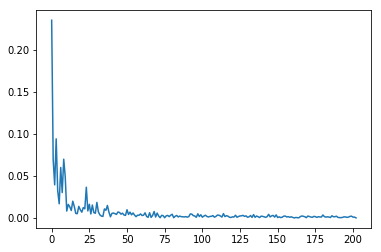

In [143]:
plot( np.sqrt(a_change**2+b_change**2) );

In [7]:
%%timeit
## Benchmark my cca function
cca = CCA_calc.CCA(3)
cca.push(X,Y)
a, b = cca.calc_ab()

633 µs ± 93.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [246]:
%%timeit
## Benchmark cca from sklearn
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=1)
cca.fit(X,Y)

6.6 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Correlation: 0.992


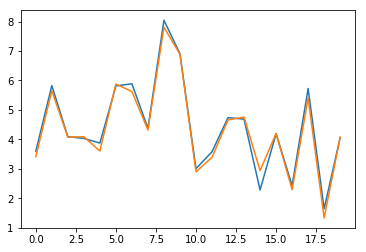

In [267]:
cca = CCA_calc.CCA(3)

cca.push(X,Y)
a, b = cca.calc_ab()

new_X = np.dot(X,a)
new_Y = np.dot(Y,b)

print('Correlation: {:.3f}'.format(np.corrcoef(new_X,new_Y)[0,1]))

plot(new_X[:20])
plot(new_Y[:20])

Correlation: 0.995


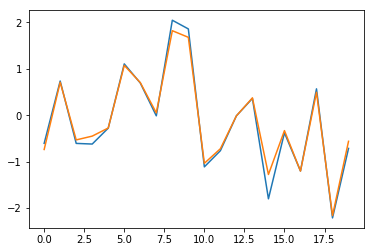

In [268]:

cca = CCA(n_components=1)
cca.fit(X,Y)

new_X,new_Y = cca.transform(X,Y)

np.corrcoef(new_X,new_Y,rowvar=False)[0,1]
print('Correlation: {:.3f}'.format( np.corrcoef(new_X,new_Y,rowvar=False)[0,1] ))

plot(new_X[:20])
plot(new_Y[:20])